In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [33]:
def add_streamline_plot_to_ax(dax, day, axs, x="longitude", y="latitude", **figkwargs):
    """
    Add a streamlines plot to a pre-existing set of axes

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    axs : matplotlib.axes.Axes
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name
    **figkwargs : optional
        An assortment of figkwargs. See the matplotlib.pyplot.streamplot documentation for details

    Returns
    -------
    p : matplotlib.pyplot.streamplot
    """



    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    lw = 25 * np.sqrt(bu**2 + bv**2)# / np.sqrt(bu**2 + bv**2).max()
    lw = np.nan_to_num(lw, nan=0.0)

    figkwargs = {
        "density": 5,
        "linewidth": lw,
        "arrowsize": 1,
        "color": magnitude,
        "cmap":'viridis',
        **figkwargs,
    }

    p = axs.streamplot(lon2d, lat2d, bu, bv, transform=ccrs.PlateCarree(), **figkwargs)

    cbar = plt.colorbar(p.lines, ax=ax, pad=0.05)
    cbar.set_label("Speed (m/s)")

    plt.title(f"Velocity Streamlines for year {year}")

    return p

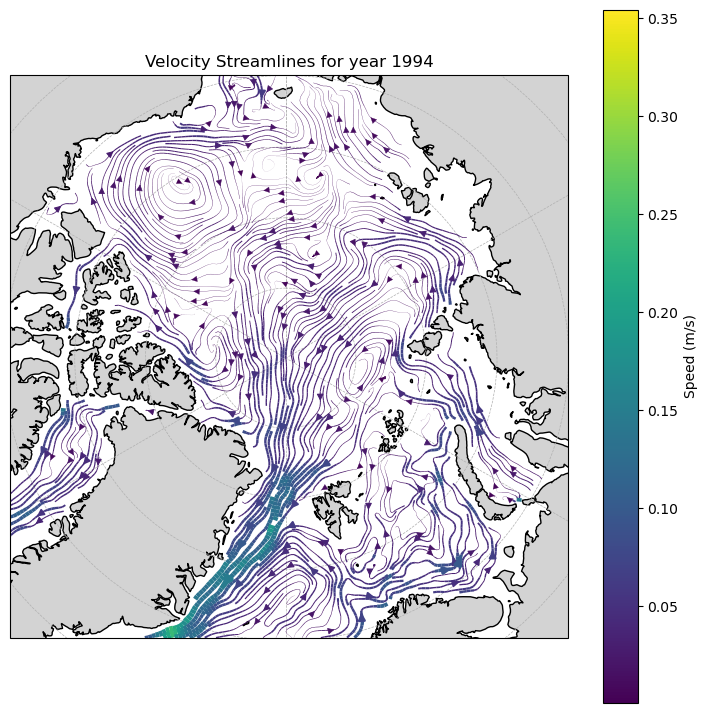

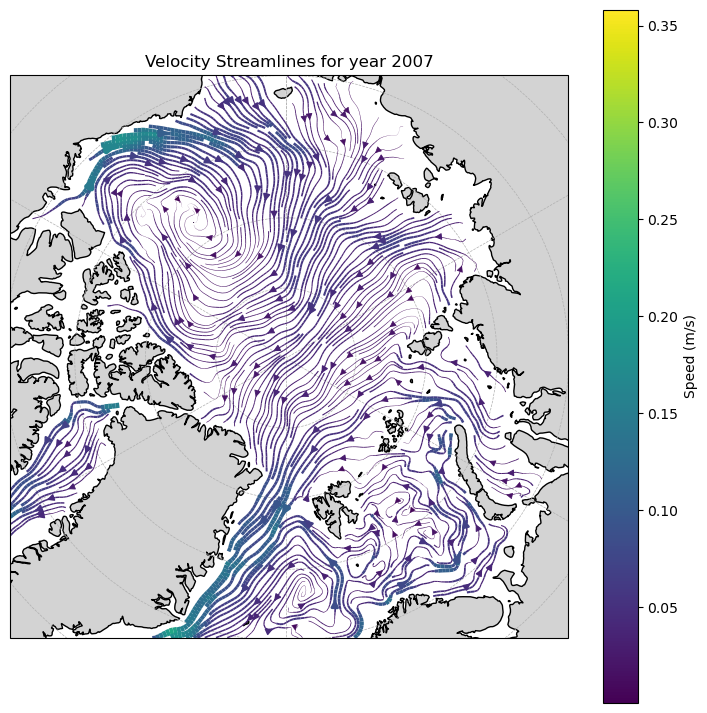

In [35]:
ds = xr.open_dataset("cmems_mod_arc_phy_my_topaz4_P1M_vxo-vyo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")
years = ["1994","2007"]
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid
for year in years:
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=proj_map)
    #
    # # Focus on Arctic (change for Antarctic)
    ax.set_extent([-180, 180, 70, 90], crs=proj_data)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.coastlines(resolution='50m')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')
    u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
    v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

    add_streamline_plot_to_ax(u,v,ax)
plt.show()